# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

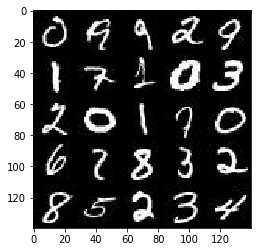

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

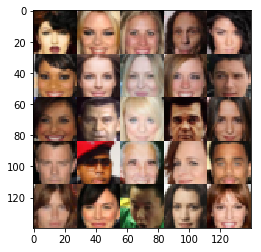

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None)
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update    
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    height, width, channel = data_shape[1:]
    
    input_real, input_z, lr = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    smooth = 0.1
    
    # determine how often to show sample image and print trainging stat
    print_per_epoch = 100
    show_per_epoch = 5
    total_samples = data_shape[0]
    total_batch_in_epoch = total_samples // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for ii, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # normalize input
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if ii > 0 and ii % (total_batch_in_epoch // print_per_epoch) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = sess.run(g_loss, {input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "{:.2f}%...".format(ii * 100.0 / total_batch_in_epoch),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                if ii > 0 and ii % (total_batch_in_epoch // show_per_epoch) == 0:
                    show_generator_output(sess, 16, tf.random_uniform((16, z_dim)), channel, data_image_mode)

    print('finished training...')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... 0.85%... Discriminator Loss: 0.7140... Generator Loss: 2.7956
Epoch 1/2... 1.71%... Discriminator Loss: 0.4536... Generator Loss: 1.4951
Epoch 1/2... 2.56%... Discriminator Loss: 0.6404... Generator Loss: 4.5818
Epoch 1/2... 3.42%... Discriminator Loss: 0.1449... Generator Loss: 4.7289
Epoch 1/2... 4.27%... Discriminator Loss: 0.0813... Generator Loss: 3.9238
Epoch 1/2... 5.13%... Discriminator Loss: 0.1494... Generator Loss: 2.1792
Epoch 1/2... 5.98%... Discriminator Loss: 0.0154... Generator Loss: 5.9901
Epoch 1/2... 6.84%... Discriminator Loss: 0.0180... Generator Loss: 4.6574
Epoch 1/2... 7.69%... Discriminator Loss: 0.0211... Generator Loss: 4.5593
Epoch 1/2... 8.55%... Discriminator Loss: 0.0186... Generator Loss: 5.0976
Epoch 1/2... 9.40%... Discriminator Loss: 0.0195... Generator Loss: 5.0618
Epoch 1/2... 10.26%... Discriminator Loss: 0.6480... Generator Loss: 7.2252
Epoch 1/2... 11.11%... Discriminator Loss: 0.1849... Generator Loss: 7.2166
Epoch 1/2... 11.97%... 

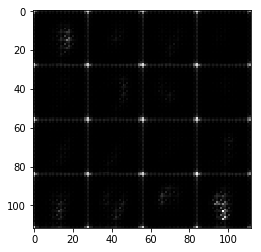

Epoch 1/2... 20.51%... Discriminator Loss: 1.1365... Generator Loss: 0.9548
Epoch 1/2... 21.37%... Discriminator Loss: 0.2829... Generator Loss: 2.9793
Epoch 1/2... 22.22%... Discriminator Loss: 0.7360... Generator Loss: 2.0427
Epoch 1/2... 23.08%... Discriminator Loss: 0.6405... Generator Loss: 1.7278
Epoch 1/2... 23.93%... Discriminator Loss: 0.3864... Generator Loss: 1.8075
Epoch 1/2... 24.79%... Discriminator Loss: 0.2469... Generator Loss: 2.8103
Epoch 1/2... 25.64%... Discriminator Loss: 0.2585... Generator Loss: 2.5364
Epoch 1/2... 26.50%... Discriminator Loss: 0.3577... Generator Loss: 2.3358
Epoch 1/2... 27.35%... Discriminator Loss: 0.5458... Generator Loss: 2.0718
Epoch 1/2... 28.21%... Discriminator Loss: 0.2770... Generator Loss: 2.6146
Epoch 1/2... 29.06%... Discriminator Loss: 0.3988... Generator Loss: 2.0119
Epoch 1/2... 29.91%... Discriminator Loss: 0.6060... Generator Loss: 1.6720
Epoch 1/2... 30.77%... Discriminator Loss: 0.6254... Generator Loss: 1.7317
Epoch 1/2...

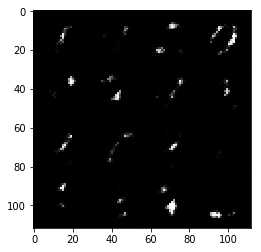

Epoch 1/2... 40.17%... Discriminator Loss: 0.3873... Generator Loss: 2.4108
Epoch 1/2... 41.03%... Discriminator Loss: 0.6528... Generator Loss: 2.3454
Epoch 1/2... 41.88%... Discriminator Loss: 0.8225... Generator Loss: 1.3291
Epoch 1/2... 42.74%... Discriminator Loss: 0.5259... Generator Loss: 1.5328
Epoch 1/2... 43.59%... Discriminator Loss: 0.3353... Generator Loss: 2.2741
Epoch 1/2... 44.44%... Discriminator Loss: 0.5437... Generator Loss: 2.1213
Epoch 1/2... 45.30%... Discriminator Loss: 0.7138... Generator Loss: 1.5595
Epoch 1/2... 46.15%... Discriminator Loss: 0.9937... Generator Loss: 3.4806
Epoch 1/2... 47.01%... Discriminator Loss: 0.5222... Generator Loss: 1.3238
Epoch 1/2... 47.86%... Discriminator Loss: 0.8440... Generator Loss: 0.9746
Epoch 1/2... 48.72%... Discriminator Loss: 0.4697... Generator Loss: 2.2150
Epoch 1/2... 49.57%... Discriminator Loss: 0.5953... Generator Loss: 1.6772
Epoch 1/2... 50.43%... Discriminator Loss: 1.2016... Generator Loss: 0.5572
Epoch 1/2...

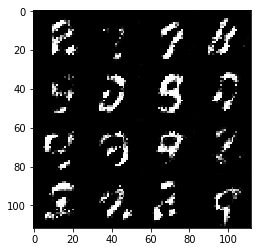

Epoch 1/2... 59.83%... Discriminator Loss: 0.2712... Generator Loss: 2.4590
Epoch 1/2... 60.68%... Discriminator Loss: 0.3879... Generator Loss: 2.5436
Epoch 1/2... 61.54%... Discriminator Loss: 0.3509... Generator Loss: 2.2629
Epoch 1/2... 62.39%... Discriminator Loss: 0.3655... Generator Loss: 1.9503
Epoch 1/2... 63.25%... Discriminator Loss: 0.2563... Generator Loss: 2.4433
Epoch 1/2... 64.10%... Discriminator Loss: 0.4960... Generator Loss: 1.4240
Epoch 1/2... 64.96%... Discriminator Loss: 2.2886... Generator Loss: 0.1860
Epoch 1/2... 65.81%... Discriminator Loss: 0.5197... Generator Loss: 1.9949
Epoch 1/2... 66.67%... Discriminator Loss: 0.7682... Generator Loss: 2.0672
Epoch 1/2... 67.52%... Discriminator Loss: 0.8280... Generator Loss: 1.2900
Epoch 1/2... 68.38%... Discriminator Loss: 0.7700... Generator Loss: 1.4346
Epoch 1/2... 69.23%... Discriminator Loss: 1.2146... Generator Loss: 1.5293
Epoch 1/2... 70.09%... Discriminator Loss: 1.7920... Generator Loss: 0.4834
Epoch 1/2...

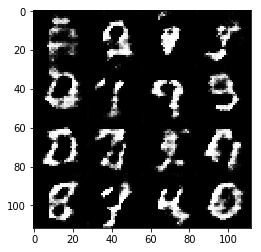

Epoch 1/2... 80.34%... Discriminator Loss: 0.6794... Generator Loss: 1.4330
Epoch 1/2... 81.20%... Discriminator Loss: 0.8772... Generator Loss: 1.1014
Epoch 1/2... 82.05%... Discriminator Loss: 1.1245... Generator Loss: 1.2552
Epoch 1/2... 82.91%... Discriminator Loss: 1.0067... Generator Loss: 1.7826
Epoch 1/2... 83.76%... Discriminator Loss: 0.8302... Generator Loss: 1.6323
Epoch 1/2... 84.62%... Discriminator Loss: 0.7293... Generator Loss: 1.3400
Epoch 1/2... 85.47%... Discriminator Loss: 0.8300... Generator Loss: 1.6833
Epoch 1/2... 86.32%... Discriminator Loss: 0.7746... Generator Loss: 1.1774
Epoch 1/2... 87.18%... Discriminator Loss: 0.8326... Generator Loss: 1.3709
Epoch 1/2... 88.03%... Discriminator Loss: 0.7304... Generator Loss: 1.6621
Epoch 1/2... 88.89%... Discriminator Loss: 0.9537... Generator Loss: 1.1618
Epoch 1/2... 89.74%... Discriminator Loss: 0.7350... Generator Loss: 1.7962
Epoch 1/2... 90.60%... Discriminator Loss: 0.6134... Generator Loss: 1.8771
Epoch 1/2...

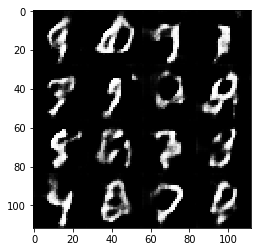

Epoch 2/2... 0.85%... Discriminator Loss: 1.0555... Generator Loss: 0.6738
Epoch 2/2... 1.71%... Discriminator Loss: 0.7904... Generator Loss: 2.1626
Epoch 2/2... 2.56%... Discriminator Loss: 0.6518... Generator Loss: 1.5081
Epoch 2/2... 3.42%... Discriminator Loss: 0.8608... Generator Loss: 1.0177
Epoch 2/2... 4.27%... Discriminator Loss: 0.7686... Generator Loss: 1.3243
Epoch 2/2... 5.13%... Discriminator Loss: 0.5626... Generator Loss: 1.4491
Epoch 2/2... 5.98%... Discriminator Loss: 0.7047... Generator Loss: 1.9382
Epoch 2/2... 6.84%... Discriminator Loss: 0.7240... Generator Loss: 1.2312
Epoch 2/2... 7.69%... Discriminator Loss: 0.8264... Generator Loss: 1.8129
Epoch 2/2... 8.55%... Discriminator Loss: 1.1019... Generator Loss: 2.3398
Epoch 2/2... 9.40%... Discriminator Loss: 0.6126... Generator Loss: 1.7304
Epoch 2/2... 10.26%... Discriminator Loss: 0.7265... Generator Loss: 1.1755
Epoch 2/2... 11.11%... Discriminator Loss: 0.7063... Generator Loss: 1.1265
Epoch 2/2... 11.97%... 

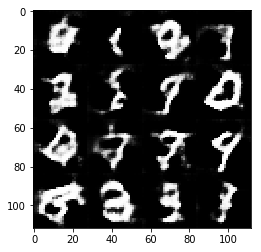

Epoch 2/2... 20.51%... Discriminator Loss: 0.6064... Generator Loss: 1.5765
Epoch 2/2... 21.37%... Discriminator Loss: 0.6939... Generator Loss: 1.4669
Epoch 2/2... 22.22%... Discriminator Loss: 0.7561... Generator Loss: 1.2561
Epoch 2/2... 23.08%... Discriminator Loss: 0.8478... Generator Loss: 1.1679
Epoch 2/2... 23.93%... Discriminator Loss: 0.8010... Generator Loss: 1.4522
Epoch 2/2... 24.79%... Discriminator Loss: 0.8009... Generator Loss: 1.0897
Epoch 2/2... 25.64%... Discriminator Loss: 0.5968... Generator Loss: 1.8992
Epoch 2/2... 26.50%... Discriminator Loss: 0.8407... Generator Loss: 1.1383
Epoch 2/2... 27.35%... Discriminator Loss: 0.7267... Generator Loss: 1.2461
Epoch 2/2... 28.21%... Discriminator Loss: 0.7727... Generator Loss: 1.1615
Epoch 2/2... 29.06%... Discriminator Loss: 0.7349... Generator Loss: 1.3285
Epoch 2/2... 29.91%... Discriminator Loss: 0.7736... Generator Loss: 1.5383
Epoch 2/2... 30.77%... Discriminator Loss: 0.6860... Generator Loss: 1.3784
Epoch 2/2...

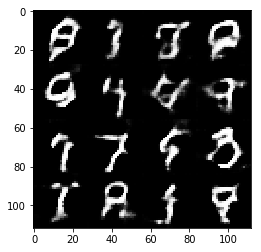

Epoch 2/2... 40.17%... Discriminator Loss: 0.9274... Generator Loss: 1.0251
Epoch 2/2... 41.03%... Discriminator Loss: 0.9165... Generator Loss: 1.2859
Epoch 2/2... 41.88%... Discriminator Loss: 0.6879... Generator Loss: 1.6375
Epoch 2/2... 42.74%... Discriminator Loss: 0.7214... Generator Loss: 1.6335
Epoch 2/2... 43.59%... Discriminator Loss: 0.7897... Generator Loss: 1.4352
Epoch 2/2... 44.44%... Discriminator Loss: 1.0903... Generator Loss: 2.4209
Epoch 2/2... 45.30%... Discriminator Loss: 0.7444... Generator Loss: 1.6132
Epoch 2/2... 46.15%... Discriminator Loss: 0.6953... Generator Loss: 1.3633
Epoch 2/2... 47.01%... Discriminator Loss: 0.9833... Generator Loss: 1.4751
Epoch 2/2... 47.86%... Discriminator Loss: 0.8513... Generator Loss: 1.3670
Epoch 2/2... 48.72%... Discriminator Loss: 0.6190... Generator Loss: 1.7405
Epoch 2/2... 49.57%... Discriminator Loss: 0.8603... Generator Loss: 1.1911
Epoch 2/2... 50.43%... Discriminator Loss: 0.7069... Generator Loss: 1.3623
Epoch 2/2...

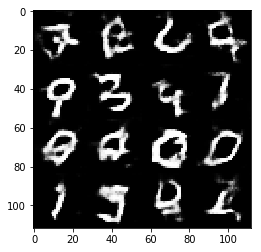

Epoch 2/2... 59.83%... Discriminator Loss: 0.7111... Generator Loss: 1.6604
Epoch 2/2... 60.68%... Discriminator Loss: 0.9228... Generator Loss: 0.9991
Epoch 2/2... 61.54%... Discriminator Loss: 0.8617... Generator Loss: 1.7913
Epoch 2/2... 62.39%... Discriminator Loss: 0.5990... Generator Loss: 1.3463
Epoch 2/2... 63.25%... Discriminator Loss: 0.6744... Generator Loss: 1.6764
Epoch 2/2... 64.10%... Discriminator Loss: 0.8304... Generator Loss: 1.1862
Epoch 2/2... 64.96%... Discriminator Loss: 0.9409... Generator Loss: 0.8022
Epoch 2/2... 65.81%... Discriminator Loss: 0.6661... Generator Loss: 1.7478
Epoch 2/2... 66.67%... Discriminator Loss: 0.7569... Generator Loss: 1.2883
Epoch 2/2... 67.52%... Discriminator Loss: 0.7077... Generator Loss: 1.2852
Epoch 2/2... 68.38%... Discriminator Loss: 0.7071... Generator Loss: 1.4562
Epoch 2/2... 69.23%... Discriminator Loss: 0.6287... Generator Loss: 1.7356
Epoch 2/2... 70.09%... Discriminator Loss: 0.7814... Generator Loss: 1.6792
Epoch 2/2...

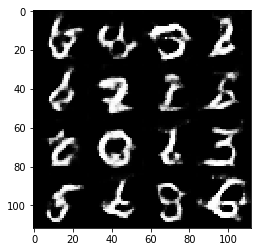

Epoch 2/2... 80.34%... Discriminator Loss: 0.6201... Generator Loss: 1.6164
Epoch 2/2... 81.20%... Discriminator Loss: 0.6623... Generator Loss: 1.5302
Epoch 2/2... 82.05%... Discriminator Loss: 0.6464... Generator Loss: 1.3220
Epoch 2/2... 82.91%... Discriminator Loss: 0.6159... Generator Loss: 1.4858
Epoch 2/2... 83.76%... Discriminator Loss: 0.5634... Generator Loss: 1.8777
Epoch 2/2... 84.62%... Discriminator Loss: 0.7013... Generator Loss: 1.0243
Epoch 2/2... 85.47%... Discriminator Loss: 0.6330... Generator Loss: 1.4597
Epoch 2/2... 86.32%... Discriminator Loss: 0.5439... Generator Loss: 1.5422
Epoch 2/2... 87.18%... Discriminator Loss: 0.7100... Generator Loss: 1.4393
Epoch 2/2... 88.03%... Discriminator Loss: 0.7330... Generator Loss: 1.0406
Epoch 2/2... 88.89%... Discriminator Loss: 0.5739... Generator Loss: 1.4229
Epoch 2/2... 89.74%... Discriminator Loss: 0.6053... Generator Loss: 1.4511
Epoch 2/2... 90.60%... Discriminator Loss: 0.6157... Generator Loss: 1.8379
Epoch 2/2...

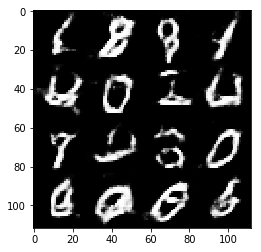

finished training...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/50... 0.95%... Discriminator Loss: 0.1638... Generator Loss: 2.2961
Epoch 1/50... 1.90%... Discriminator Loss: 0.0855... Generator Loss: 3.0872
Epoch 1/50... 2.84%... Discriminator Loss: 0.2267... Generator Loss: 2.1500
Epoch 1/50... 3.79%... Discriminator Loss: 0.2534... Generator Loss: 6.1592
Epoch 1/50... 4.74%... Discriminator Loss: 0.1462... Generator Loss: 2.9403
Epoch 1/50... 5.69%... Discriminator Loss: 0.3262... Generator Loss: 2.4824
Epoch 1/50... 6.64%... Discriminator Loss: 0.2207... Generator Loss: 2.2991
Epoch 1/50... 7.59%... Discriminator Loss: 0.0874... Generator Loss: 3.3755
Epoch 1/50... 8.53%... Discriminator Loss: 0.1366... Generator Loss: 3.2323
Epoch 1/50... 9.48%... Discriminator Loss: 0.0744... Generator Loss: 3.6425
Epoch 1/50... 10.43%... Discriminator Loss: 0.2689... Generator Loss: 2.0733
Epoch 1/50... 11.38%... Discriminator Loss: 0.0162... Generator Loss: 5.0942
Epoch 1/50... 12.33%... Discriminator Loss: 0.4794... Generator Loss: 1.7229
Epoch 1/5

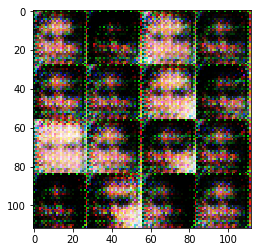

Epoch 1/50... 20.86%... Discriminator Loss: 1.0148... Generator Loss: 6.7490
Epoch 1/50... 21.81%... Discriminator Loss: 0.4042... Generator Loss: 2.5017
Epoch 1/50... 22.76%... Discriminator Loss: 0.7349... Generator Loss: 1.4040
Epoch 1/50... 23.70%... Discriminator Loss: 0.4484... Generator Loss: 1.7145
Epoch 1/50... 24.65%... Discriminator Loss: 0.4221... Generator Loss: 2.3295
Epoch 1/50... 25.60%... Discriminator Loss: 0.5312... Generator Loss: 1.5808
Epoch 1/50... 26.55%... Discriminator Loss: 0.6209... Generator Loss: 2.1141
Epoch 1/50... 27.50%... Discriminator Loss: 0.4212... Generator Loss: 1.8130
Epoch 1/50... 28.45%... Discriminator Loss: 0.6401... Generator Loss: 1.9774
Epoch 1/50... 29.39%... Discriminator Loss: 1.0855... Generator Loss: 0.7036
Epoch 1/50... 30.34%... Discriminator Loss: 0.9793... Generator Loss: 2.1033
Epoch 1/50... 31.29%... Discriminator Loss: 0.5017... Generator Loss: 1.8531
Epoch 1/50... 32.24%... Discriminator Loss: 1.0787... Generator Loss: 1.5321

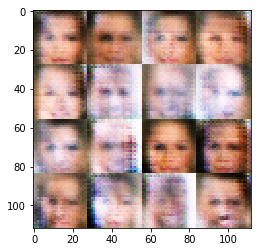

Epoch 1/50... 40.77%... Discriminator Loss: 0.7824... Generator Loss: 1.6607
Epoch 1/50... 41.72%... Discriminator Loss: 0.5320... Generator Loss: 1.9235
Epoch 1/50... 42.67%... Discriminator Loss: 0.5949... Generator Loss: 1.6019
Epoch 1/50... 43.62%... Discriminator Loss: 0.9032... Generator Loss: 1.5258
Epoch 1/50... 44.56%... Discriminator Loss: 1.2302... Generator Loss: 1.2401
Epoch 1/50... 45.51%... Discriminator Loss: 0.4976... Generator Loss: 1.9860
Epoch 1/50... 46.46%... Discriminator Loss: 0.8547... Generator Loss: 1.8697
Epoch 1/50... 47.41%... Discriminator Loss: 0.7399... Generator Loss: 1.8653
Epoch 1/50... 48.36%... Discriminator Loss: 1.0416... Generator Loss: 1.2868
Epoch 1/50... 49.30%... Discriminator Loss: 1.0803... Generator Loss: 0.8833
Epoch 1/50... 50.25%... Discriminator Loss: 1.3349... Generator Loss: 0.6460
Epoch 1/50... 51.20%... Discriminator Loss: 0.9663... Generator Loss: 1.2077
Epoch 1/50... 52.15%... Discriminator Loss: 0.9352... Generator Loss: 1.5035

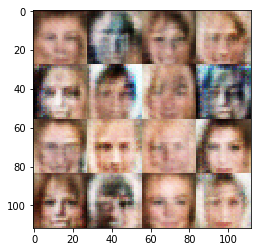

Epoch 1/50... 60.68%... Discriminator Loss: 1.0226... Generator Loss: 1.1382
Epoch 1/50... 61.63%... Discriminator Loss: 0.5524... Generator Loss: 1.8193
Epoch 1/50... 62.58%... Discriminator Loss: 1.5646... Generator Loss: 0.3714
Epoch 1/50... 63.53%... Discriminator Loss: 1.0313... Generator Loss: 1.2554
Epoch 1/50... 64.48%... Discriminator Loss: 1.7476... Generator Loss: 0.3080
Epoch 1/50... 65.42%... Discriminator Loss: 0.8195... Generator Loss: 2.6488
Epoch 1/50... 66.37%... Discriminator Loss: 0.8258... Generator Loss: 1.0775
Epoch 1/50... 67.32%... Discriminator Loss: 0.8639... Generator Loss: 1.8358
Epoch 1/50... 68.27%... Discriminator Loss: 0.8449... Generator Loss: 1.3933
Epoch 1/50... 69.22%... Discriminator Loss: 0.9604... Generator Loss: 1.0241
Epoch 1/50... 70.16%... Discriminator Loss: 1.0438... Generator Loss: 1.3760
Epoch 1/50... 71.11%... Discriminator Loss: 0.7353... Generator Loss: 2.0236
Epoch 1/50... 72.06%... Discriminator Loss: 0.7044... Generator Loss: 2.3177

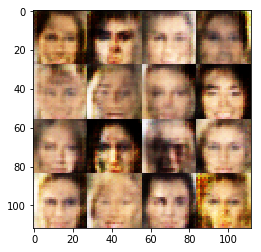

Epoch 1/50... 80.59%... Discriminator Loss: 0.9368... Generator Loss: 0.8987
Epoch 1/50... 81.54%... Discriminator Loss: 1.2727... Generator Loss: 0.8212
Epoch 1/50... 82.49%... Discriminator Loss: 0.6064... Generator Loss: 1.7895
Epoch 1/50... 83.44%... Discriminator Loss: 0.7893... Generator Loss: 1.3789
Epoch 1/50... 84.39%... Discriminator Loss: 1.4754... Generator Loss: 1.8892
Epoch 1/50... 85.34%... Discriminator Loss: 0.4428... Generator Loss: 1.5396
Epoch 1/50... 86.28%... Discriminator Loss: 0.9852... Generator Loss: 0.9577
Epoch 1/50... 87.23%... Discriminator Loss: 0.5964... Generator Loss: 1.3506
Epoch 1/50... 88.18%... Discriminator Loss: 1.4627... Generator Loss: 0.4881
Epoch 1/50... 89.13%... Discriminator Loss: 1.2751... Generator Loss: 0.5418
Epoch 1/50... 90.08%... Discriminator Loss: 0.8615... Generator Loss: 1.5217
Epoch 1/50... 91.02%... Discriminator Loss: 0.7148... Generator Loss: 1.3734
Epoch 1/50... 91.97%... Discriminator Loss: 1.1034... Generator Loss: 0.8310

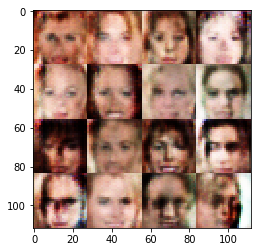

Epoch 2/50... 0.95%... Discriminator Loss: 1.9275... Generator Loss: 0.4834
Epoch 2/50... 1.90%... Discriminator Loss: 0.8844... Generator Loss: 0.8914
Epoch 2/50... 2.84%... Discriminator Loss: 0.8597... Generator Loss: 1.0450
Epoch 2/50... 3.79%... Discriminator Loss: 1.3467... Generator Loss: 0.6160
Epoch 2/50... 4.74%... Discriminator Loss: 1.1432... Generator Loss: 1.4440
Epoch 2/50... 5.69%... Discriminator Loss: 0.6981... Generator Loss: 1.8077
Epoch 2/50... 6.64%... Discriminator Loss: 0.8613... Generator Loss: 2.0621
Epoch 2/50... 7.59%... Discriminator Loss: 0.9970... Generator Loss: 1.2653
Epoch 2/50... 8.53%... Discriminator Loss: 1.0625... Generator Loss: 1.1416
Epoch 2/50... 9.48%... Discriminator Loss: 1.2866... Generator Loss: 0.7980
Epoch 2/50... 10.43%... Discriminator Loss: 1.2325... Generator Loss: 1.0218
Epoch 2/50... 11.38%... Discriminator Loss: 1.2483... Generator Loss: 0.9093
Epoch 2/50... 12.33%... Discriminator Loss: 1.0614... Generator Loss: 0.7733
Epoch 2/5

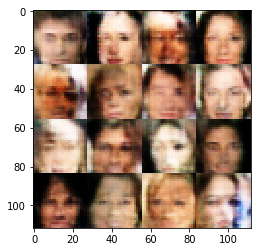

Epoch 2/50... 20.86%... Discriminator Loss: 0.7586... Generator Loss: 2.1961
Epoch 2/50... 21.81%... Discriminator Loss: 1.0557... Generator Loss: 2.0228
Epoch 2/50... 22.76%... Discriminator Loss: 0.6787... Generator Loss: 1.4181
Epoch 2/50... 23.70%... Discriminator Loss: 0.3877... Generator Loss: 2.2178
Epoch 2/50... 24.65%... Discriminator Loss: 1.1126... Generator Loss: 1.0304
Epoch 2/50... 25.60%... Discriminator Loss: 0.9083... Generator Loss: 0.9155
Epoch 2/50... 26.55%... Discriminator Loss: 1.2234... Generator Loss: 2.7898
Epoch 2/50... 27.50%... Discriminator Loss: 0.9352... Generator Loss: 0.9255
Epoch 2/50... 28.45%... Discriminator Loss: 1.3379... Generator Loss: 0.5723
Epoch 2/50... 29.39%... Discriminator Loss: 0.7527... Generator Loss: 1.4149
Epoch 2/50... 30.34%... Discriminator Loss: 0.7432... Generator Loss: 1.3808
Epoch 2/50... 31.29%... Discriminator Loss: 0.6577... Generator Loss: 1.3397
Epoch 2/50... 32.24%... Discriminator Loss: 1.0880... Generator Loss: 1.1198

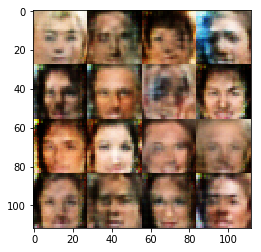

Epoch 2/50... 40.77%... Discriminator Loss: 1.0730... Generator Loss: 0.6963
Epoch 2/50... 41.72%... Discriminator Loss: 0.8273... Generator Loss: 1.3819
Epoch 2/50... 42.67%... Discriminator Loss: 0.8200... Generator Loss: 1.9065
Epoch 2/50... 43.62%... Discriminator Loss: 0.9710... Generator Loss: 0.9002
Epoch 2/50... 44.56%... Discriminator Loss: 1.0181... Generator Loss: 0.9974
Epoch 2/50... 45.51%... Discriminator Loss: 0.9132... Generator Loss: 0.8821
Epoch 2/50... 46.46%... Discriminator Loss: 1.0554... Generator Loss: 0.9625
Epoch 2/50... 47.41%... Discriminator Loss: 1.5126... Generator Loss: 1.7587
Epoch 2/50... 48.36%... Discriminator Loss: 1.0081... Generator Loss: 1.3442
Epoch 2/50... 49.30%... Discriminator Loss: 1.5084... Generator Loss: 0.3869
Epoch 2/50... 50.25%... Discriminator Loss: 0.9364... Generator Loss: 0.8935
Epoch 2/50... 51.20%... Discriminator Loss: 1.0111... Generator Loss: 1.0723
Epoch 2/50... 52.15%... Discriminator Loss: 1.2172... Generator Loss: 0.5231

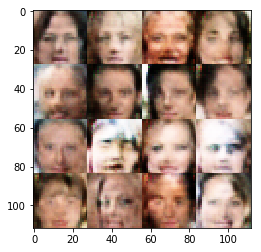

Epoch 2/50... 60.68%... Discriminator Loss: 1.8348... Generator Loss: 0.2959
Epoch 2/50... 61.63%... Discriminator Loss: 0.9277... Generator Loss: 1.1974
Epoch 2/50... 62.58%... Discriminator Loss: 0.9024... Generator Loss: 1.0104
Epoch 2/50... 63.53%... Discriminator Loss: 1.2639... Generator Loss: 0.6007
Epoch 2/50... 64.48%... Discriminator Loss: 1.2537... Generator Loss: 0.8845
Epoch 2/50... 65.42%... Discriminator Loss: 0.7451... Generator Loss: 1.7674
Epoch 2/50... 66.37%... Discriminator Loss: 0.6824... Generator Loss: 1.4407
Epoch 2/50... 67.32%... Discriminator Loss: 1.4434... Generator Loss: 0.6322
Epoch 2/50... 68.27%... Discriminator Loss: 1.1909... Generator Loss: 0.8521
Epoch 2/50... 69.22%... Discriminator Loss: 0.8671... Generator Loss: 1.4603
Epoch 2/50... 70.16%... Discriminator Loss: 0.8028... Generator Loss: 1.7786
Epoch 2/50... 71.11%... Discriminator Loss: 0.6378... Generator Loss: 1.1414
Epoch 2/50... 72.06%... Discriminator Loss: 1.8754... Generator Loss: 2.7015

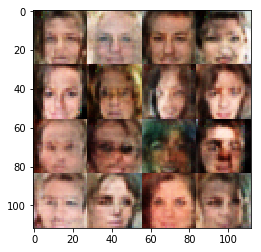

Epoch 2/50... 80.59%... Discriminator Loss: 1.2455... Generator Loss: 1.2319
Epoch 2/50... 81.54%... Discriminator Loss: 1.1077... Generator Loss: 1.1015
Epoch 2/50... 82.49%... Discriminator Loss: 0.9853... Generator Loss: 1.1008
Epoch 2/50... 83.44%... Discriminator Loss: 0.9082... Generator Loss: 1.1175
Epoch 2/50... 84.39%... Discriminator Loss: 0.9263... Generator Loss: 1.2638
Epoch 2/50... 85.34%... Discriminator Loss: 0.7596... Generator Loss: 1.3861
Epoch 2/50... 86.28%... Discriminator Loss: 1.3696... Generator Loss: 1.3808
Epoch 2/50... 87.23%... Discriminator Loss: 0.8222... Generator Loss: 1.5890
Epoch 2/50... 88.18%... Discriminator Loss: 1.0163... Generator Loss: 0.8544
Epoch 2/50... 89.13%... Discriminator Loss: 0.9471... Generator Loss: 1.5719
Epoch 2/50... 90.08%... Discriminator Loss: 1.5134... Generator Loss: 2.1327
Epoch 2/50... 91.02%... Discriminator Loss: 1.2344... Generator Loss: 0.7784
Epoch 2/50... 91.97%... Discriminator Loss: 0.9997... Generator Loss: 1.1684

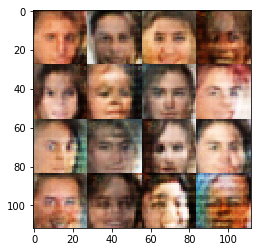

Epoch 3/50... 0.95%... Discriminator Loss: 1.0796... Generator Loss: 0.9017
Epoch 3/50... 1.90%... Discriminator Loss: 1.0795... Generator Loss: 0.6330
Epoch 3/50... 2.84%... Discriminator Loss: 0.8282... Generator Loss: 1.7069
Epoch 3/50... 3.79%... Discriminator Loss: 0.9803... Generator Loss: 0.8587
Epoch 3/50... 4.74%... Discriminator Loss: 1.0858... Generator Loss: 0.6632
Epoch 3/50... 5.69%... Discriminator Loss: 0.8176... Generator Loss: 1.5280
Epoch 3/50... 6.64%... Discriminator Loss: 1.0541... Generator Loss: 2.0811
Epoch 3/50... 7.59%... Discriminator Loss: 0.8583... Generator Loss: 1.1019
Epoch 3/50... 8.53%... Discriminator Loss: 1.1167... Generator Loss: 0.9309
Epoch 3/50... 9.48%... Discriminator Loss: 0.7471... Generator Loss: 1.0937
Epoch 3/50... 10.43%... Discriminator Loss: 0.9332... Generator Loss: 0.8715
Epoch 3/50... 11.38%... Discriminator Loss: 1.0144... Generator Loss: 1.0706
Epoch 3/50... 12.33%... Discriminator Loss: 0.9018... Generator Loss: 1.4915
Epoch 3/5

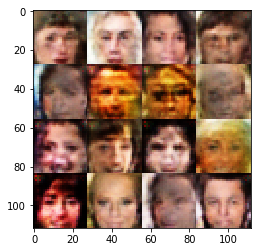

Epoch 3/50... 20.86%... Discriminator Loss: 0.9631... Generator Loss: 1.0348
Epoch 3/50... 21.81%... Discriminator Loss: 1.1913... Generator Loss: 0.5919
Epoch 3/50... 22.76%... Discriminator Loss: 0.9083... Generator Loss: 0.9276
Epoch 3/50... 23.70%... Discriminator Loss: 0.7356... Generator Loss: 1.9517
Epoch 3/50... 24.65%... Discriminator Loss: 0.6470... Generator Loss: 1.4710
Epoch 3/50... 25.60%... Discriminator Loss: 0.9032... Generator Loss: 1.0217
Epoch 3/50... 26.55%... Discriminator Loss: 1.2479... Generator Loss: 1.1482
Epoch 3/50... 27.50%... Discriminator Loss: 0.9307... Generator Loss: 1.1595
Epoch 3/50... 28.45%... Discriminator Loss: 0.6244... Generator Loss: 1.3111
Epoch 3/50... 29.39%... Discriminator Loss: 0.9629... Generator Loss: 1.3154
Epoch 3/50... 30.34%... Discriminator Loss: 1.0305... Generator Loss: 0.8710
Epoch 3/50... 31.29%... Discriminator Loss: 1.1597... Generator Loss: 1.2282
Epoch 3/50... 32.24%... Discriminator Loss: 0.8126... Generator Loss: 0.8665

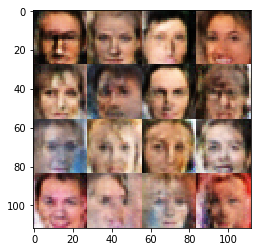

Epoch 3/50... 40.77%... Discriminator Loss: 1.1020... Generator Loss: 0.6266
Epoch 3/50... 41.72%... Discriminator Loss: 1.1615... Generator Loss: 0.5386
Epoch 3/50... 42.67%... Discriminator Loss: 1.4946... Generator Loss: 0.6336
Epoch 3/50... 43.62%... Discriminator Loss: 0.6199... Generator Loss: 1.3659
Epoch 3/50... 44.56%... Discriminator Loss: 1.0404... Generator Loss: 1.0657
Epoch 3/50... 45.51%... Discriminator Loss: 0.9650... Generator Loss: 1.6690
Epoch 3/50... 46.46%... Discriminator Loss: 1.1800... Generator Loss: 0.7666
Epoch 3/50... 47.41%... Discriminator Loss: 0.8735... Generator Loss: 1.5100
Epoch 3/50... 48.36%... Discriminator Loss: 0.9879... Generator Loss: 0.8975
Epoch 3/50... 49.30%... Discriminator Loss: 0.8297... Generator Loss: 1.7628
Epoch 3/50... 50.25%... Discriminator Loss: 0.7895... Generator Loss: 1.3868
Epoch 3/50... 51.20%... Discriminator Loss: 1.0229... Generator Loss: 1.0429
Epoch 3/50... 52.15%... Discriminator Loss: 1.0840... Generator Loss: 1.0898

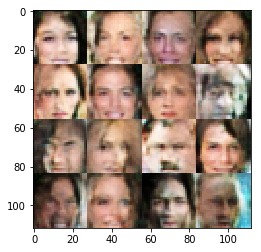

Epoch 3/50... 60.68%... Discriminator Loss: 1.0229... Generator Loss: 0.8567
Epoch 3/50... 61.63%... Discriminator Loss: 0.7435... Generator Loss: 2.0473
Epoch 3/50... 62.58%... Discriminator Loss: 0.7274... Generator Loss: 1.9463
Epoch 3/50... 63.53%... Discriminator Loss: 1.2642... Generator Loss: 0.5818
Epoch 3/50... 64.48%... Discriminator Loss: 0.9701... Generator Loss: 0.7955
Epoch 3/50... 65.42%... Discriminator Loss: 0.8563... Generator Loss: 0.8806
Epoch 3/50... 66.37%... Discriminator Loss: 0.8662... Generator Loss: 1.0645
Epoch 3/50... 67.32%... Discriminator Loss: 1.1104... Generator Loss: 0.7690
Epoch 3/50... 68.27%... Discriminator Loss: 0.8110... Generator Loss: 1.4937
Epoch 3/50... 69.22%... Discriminator Loss: 1.2176... Generator Loss: 0.9113
Epoch 3/50... 70.16%... Discriminator Loss: 0.7097... Generator Loss: 1.7282
Epoch 3/50... 71.11%... Discriminator Loss: 1.0420... Generator Loss: 1.4240
Epoch 3/50... 72.06%... Discriminator Loss: 1.2453... Generator Loss: 0.5361

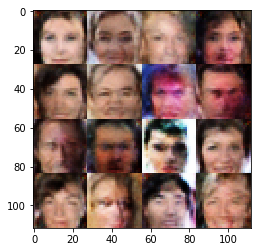

Epoch 3/50... 80.59%... Discriminator Loss: 1.0126... Generator Loss: 0.8642
Epoch 3/50... 81.54%... Discriminator Loss: 1.1228... Generator Loss: 1.4372
Epoch 3/50... 82.49%... Discriminator Loss: 0.6640... Generator Loss: 1.3704
Epoch 3/50... 83.44%... Discriminator Loss: 1.2318... Generator Loss: 0.5617
Epoch 3/50... 84.39%... Discriminator Loss: 1.1638... Generator Loss: 0.8221
Epoch 3/50... 85.34%... Discriminator Loss: 0.9913... Generator Loss: 1.1430
Epoch 3/50... 86.28%... Discriminator Loss: 0.9994... Generator Loss: 1.2724
Epoch 3/50... 87.23%... Discriminator Loss: 0.8862... Generator Loss: 1.0658
Epoch 3/50... 88.18%... Discriminator Loss: 1.0014... Generator Loss: 0.8670
Epoch 3/50... 89.13%... Discriminator Loss: 0.3336... Generator Loss: 2.5279
Epoch 3/50... 90.08%... Discriminator Loss: 0.8058... Generator Loss: 0.9421
Epoch 3/50... 91.02%... Discriminator Loss: 1.3094... Generator Loss: 0.5276
Epoch 3/50... 91.97%... Discriminator Loss: 1.2374... Generator Loss: 0.5553

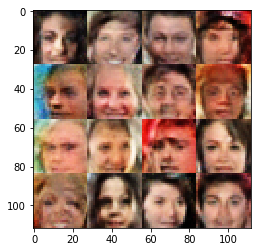

Epoch 4/50... 0.95%... Discriminator Loss: 1.1798... Generator Loss: 1.0224
Epoch 4/50... 1.90%... Discriminator Loss: 1.0202... Generator Loss: 0.8969
Epoch 4/50... 2.84%... Discriminator Loss: 1.0977... Generator Loss: 0.9856
Epoch 4/50... 3.79%... Discriminator Loss: 1.6851... Generator Loss: 2.7375
Epoch 4/50... 4.74%... Discriminator Loss: 1.0579... Generator Loss: 1.0239
Epoch 4/50... 5.69%... Discriminator Loss: 0.6458... Generator Loss: 1.8485
Epoch 4/50... 6.64%... Discriminator Loss: 1.0691... Generator Loss: 0.9412
Epoch 4/50... 7.59%... Discriminator Loss: 1.0821... Generator Loss: 0.9914
Epoch 4/50... 8.53%... Discriminator Loss: 0.8772... Generator Loss: 1.2352
Epoch 4/50... 9.48%... Discriminator Loss: 1.0746... Generator Loss: 0.8319
Epoch 4/50... 10.43%... Discriminator Loss: 1.6277... Generator Loss: 0.3753
Epoch 4/50... 11.38%... Discriminator Loss: 1.1245... Generator Loss: 0.7447
Epoch 4/50... 12.33%... Discriminator Loss: 0.9790... Generator Loss: 1.1357
Epoch 4/5

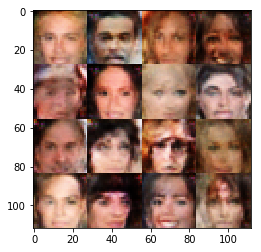

Epoch 4/50... 20.86%... Discriminator Loss: 1.1156... Generator Loss: 0.7670
Epoch 4/50... 21.81%... Discriminator Loss: 1.0055... Generator Loss: 1.0704
Epoch 4/50... 22.76%... Discriminator Loss: 1.3051... Generator Loss: 0.7525
Epoch 4/50... 23.70%... Discriminator Loss: 0.8392... Generator Loss: 1.0231
Epoch 4/50... 24.65%... Discriminator Loss: 1.2030... Generator Loss: 1.9343
Epoch 4/50... 25.60%... Discriminator Loss: 1.0084... Generator Loss: 1.1985
Epoch 4/50... 26.55%... Discriminator Loss: 1.0740... Generator Loss: 1.1779
Epoch 4/50... 27.50%... Discriminator Loss: 0.7891... Generator Loss: 1.2178
Epoch 4/50... 28.45%... Discriminator Loss: 1.0996... Generator Loss: 0.8886
Epoch 4/50... 29.39%... Discriminator Loss: 0.9809... Generator Loss: 0.8466
Epoch 4/50... 30.34%... Discriminator Loss: 1.2215... Generator Loss: 0.9087
Epoch 4/50... 31.29%... Discriminator Loss: 1.1825... Generator Loss: 0.7187
Epoch 4/50... 32.24%... Discriminator Loss: 1.1518... Generator Loss: 1.6586

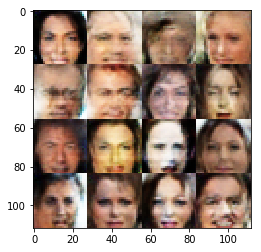

Epoch 4/50... 40.77%... Discriminator Loss: 0.9758... Generator Loss: 0.7529
Epoch 4/50... 41.72%... Discriminator Loss: 1.1937... Generator Loss: 0.5431
Epoch 4/50... 42.67%... Discriminator Loss: 1.1549... Generator Loss: 0.6807
Epoch 4/50... 43.62%... Discriminator Loss: 0.9168... Generator Loss: 1.0842
Epoch 4/50... 44.56%... Discriminator Loss: 1.0412... Generator Loss: 1.4494
Epoch 4/50... 45.51%... Discriminator Loss: 0.9648... Generator Loss: 0.9701
Epoch 4/50... 46.46%... Discriminator Loss: 1.1005... Generator Loss: 0.8681
Epoch 4/50... 47.41%... Discriminator Loss: 1.0070... Generator Loss: 1.4425
Epoch 4/50... 48.36%... Discriminator Loss: 0.5940... Generator Loss: 1.6105
Epoch 4/50... 49.30%... Discriminator Loss: 0.7977... Generator Loss: 0.8709
Epoch 4/50... 50.25%... Discriminator Loss: 0.9168... Generator Loss: 1.0356
Epoch 4/50... 51.20%... Discriminator Loss: 1.1026... Generator Loss: 0.8838
Epoch 4/50... 52.15%... Discriminator Loss: 1.0006... Generator Loss: 1.0146

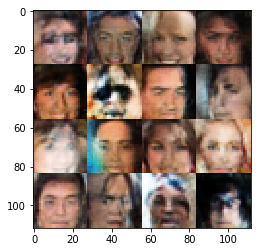

Epoch 4/50... 60.68%... Discriminator Loss: 1.1989... Generator Loss: 0.6501
Epoch 4/50... 61.63%... Discriminator Loss: 0.9047... Generator Loss: 1.8887
Epoch 4/50... 62.58%... Discriminator Loss: 1.0304... Generator Loss: 0.9758
Epoch 4/50... 63.53%... Discriminator Loss: 1.1641... Generator Loss: 1.2321
Epoch 4/50... 64.48%... Discriminator Loss: 1.0174... Generator Loss: 0.8975
Epoch 4/50... 65.42%... Discriminator Loss: 1.1234... Generator Loss: 0.6969
Epoch 4/50... 66.37%... Discriminator Loss: 0.6389... Generator Loss: 1.5964
Epoch 4/50... 67.32%... Discriminator Loss: 0.7077... Generator Loss: 1.4262
Epoch 4/50... 68.27%... Discriminator Loss: 0.9438... Generator Loss: 1.1903
Epoch 4/50... 69.22%... Discriminator Loss: 1.0825... Generator Loss: 1.0959
Epoch 4/50... 70.16%... Discriminator Loss: 1.0059... Generator Loss: 1.3002
Epoch 4/50... 71.11%... Discriminator Loss: 1.0704... Generator Loss: 1.3217
Epoch 4/50... 72.06%... Discriminator Loss: 1.2033... Generator Loss: 0.8194

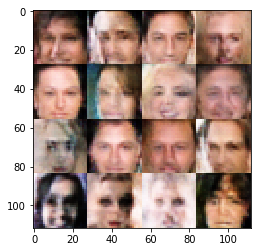

Epoch 4/50... 80.59%... Discriminator Loss: 1.1210... Generator Loss: 0.9626
Epoch 4/50... 81.54%... Discriminator Loss: 0.9941... Generator Loss: 0.9248
Epoch 4/50... 82.49%... Discriminator Loss: 1.1577... Generator Loss: 0.8587
Epoch 4/50... 83.44%... Discriminator Loss: 1.3117... Generator Loss: 1.3082
Epoch 4/50... 84.39%... Discriminator Loss: 0.9882... Generator Loss: 1.0859
Epoch 4/50... 85.34%... Discriminator Loss: 1.1531... Generator Loss: 1.0094
Epoch 4/50... 86.28%... Discriminator Loss: 1.1045... Generator Loss: 1.2101
Epoch 4/50... 87.23%... Discriminator Loss: 1.1565... Generator Loss: 1.0403
Epoch 4/50... 88.18%... Discriminator Loss: 1.0537... Generator Loss: 0.7791
Epoch 4/50... 89.13%... Discriminator Loss: 1.0279... Generator Loss: 0.7335
Epoch 4/50... 90.08%... Discriminator Loss: 0.8134... Generator Loss: 1.5630
Epoch 4/50... 91.02%... Discriminator Loss: 1.1499... Generator Loss: 0.7277
Epoch 4/50... 91.97%... Discriminator Loss: 1.0924... Generator Loss: 0.7507

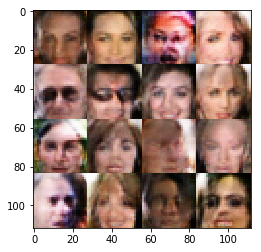

Epoch 5/50... 0.95%... Discriminator Loss: 1.3122... Generator Loss: 0.6215
Epoch 5/50... 1.90%... Discriminator Loss: 0.4103... Generator Loss: 2.4742
Epoch 5/50... 2.84%... Discriminator Loss: 1.1740... Generator Loss: 0.7474
Epoch 5/50... 3.79%... Discriminator Loss: 1.0877... Generator Loss: 0.9077
Epoch 5/50... 4.74%... Discriminator Loss: 1.0601... Generator Loss: 0.7731
Epoch 5/50... 5.69%... Discriminator Loss: 0.8607... Generator Loss: 1.2274
Epoch 5/50... 6.64%... Discriminator Loss: 1.1705... Generator Loss: 1.0353
Epoch 5/50... 7.59%... Discriminator Loss: 1.2679... Generator Loss: 0.8347
Epoch 5/50... 8.53%... Discriminator Loss: 1.0464... Generator Loss: 1.1894
Epoch 5/50... 9.48%... Discriminator Loss: 0.9557... Generator Loss: 3.1234
Epoch 5/50... 10.43%... Discriminator Loss: 1.0498... Generator Loss: 1.0826
Epoch 5/50... 11.38%... Discriminator Loss: 1.1699... Generator Loss: 0.6768
Epoch 5/50... 12.33%... Discriminator Loss: 1.9391... Generator Loss: 2.4020
Epoch 5/5

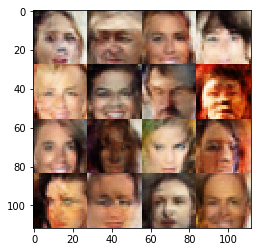

Epoch 5/50... 20.86%... Discriminator Loss: 1.2659... Generator Loss: 0.7738
Epoch 5/50... 21.81%... Discriminator Loss: 1.0303... Generator Loss: 0.7878
Epoch 5/50... 22.76%... Discriminator Loss: 0.9852... Generator Loss: 1.3143
Epoch 5/50... 23.70%... Discriminator Loss: 0.6002... Generator Loss: 1.5615
Epoch 5/50... 24.65%... Discriminator Loss: 1.7358... Generator Loss: 0.3655
Epoch 5/50... 25.60%... Discriminator Loss: 0.7551... Generator Loss: 1.3715
Epoch 5/50... 26.55%... Discriminator Loss: 1.2413... Generator Loss: 1.1948
Epoch 5/50... 27.50%... Discriminator Loss: 0.9594... Generator Loss: 0.8996
Epoch 5/50... 28.45%... Discriminator Loss: 1.2068... Generator Loss: 1.1222
Epoch 5/50... 29.39%... Discriminator Loss: 1.0098... Generator Loss: 1.4992
Epoch 5/50... 30.34%... Discriminator Loss: 1.2619... Generator Loss: 1.3457
Epoch 5/50... 31.29%... Discriminator Loss: 1.0368... Generator Loss: 1.0538
Epoch 5/50... 32.24%... Discriminator Loss: 0.7844... Generator Loss: 1.3902

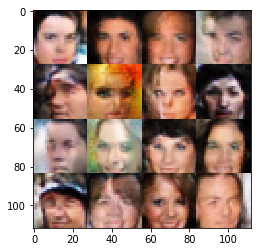

Epoch 5/50... 40.77%... Discriminator Loss: 0.8224... Generator Loss: 1.0811
Epoch 5/50... 41.72%... Discriminator Loss: 0.9455... Generator Loss: 0.8361
Epoch 5/50... 42.67%... Discriminator Loss: 0.7826... Generator Loss: 1.1758
Epoch 5/50... 43.62%... Discriminator Loss: 1.5134... Generator Loss: 0.3637
Epoch 5/50... 44.56%... Discriminator Loss: 1.2770... Generator Loss: 0.7535
Epoch 5/50... 45.51%... Discriminator Loss: 1.0785... Generator Loss: 1.0100
Epoch 5/50... 46.46%... Discriminator Loss: 1.2576... Generator Loss: 0.8279
Epoch 5/50... 47.41%... Discriminator Loss: 1.1674... Generator Loss: 0.8574
Epoch 5/50... 48.36%... Discriminator Loss: 1.2580... Generator Loss: 0.4599
Epoch 5/50... 49.30%... Discriminator Loss: 0.9651... Generator Loss: 1.0633
Epoch 5/50... 50.25%... Discriminator Loss: 1.0377... Generator Loss: 0.8285
Epoch 5/50... 51.20%... Discriminator Loss: 1.1431... Generator Loss: 0.9782
Epoch 5/50... 52.15%... Discriminator Loss: 1.3292... Generator Loss: 0.6809

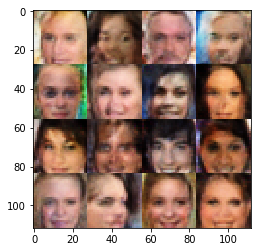

Epoch 5/50... 60.68%... Discriminator Loss: 0.8118... Generator Loss: 1.3523
Epoch 5/50... 61.63%... Discriminator Loss: 1.0251... Generator Loss: 0.9047
Epoch 5/50... 62.58%... Discriminator Loss: 0.8291... Generator Loss: 1.2123
Epoch 5/50... 63.53%... Discriminator Loss: 1.0062... Generator Loss: 0.8187
Epoch 5/50... 64.48%... Discriminator Loss: 1.2078... Generator Loss: 0.6250
Epoch 5/50... 65.42%... Discriminator Loss: 0.7985... Generator Loss: 1.4232
Epoch 5/50... 66.37%... Discriminator Loss: 1.2442... Generator Loss: 0.5313
Epoch 5/50... 67.32%... Discriminator Loss: 0.8683... Generator Loss: 1.2548
Epoch 5/50... 68.27%... Discriminator Loss: 1.1244... Generator Loss: 0.8673
Epoch 5/50... 69.22%... Discriminator Loss: 1.2040... Generator Loss: 0.8983
Epoch 5/50... 70.16%... Discriminator Loss: 0.8753... Generator Loss: 1.2200
Epoch 5/50... 71.11%... Discriminator Loss: 1.0088... Generator Loss: 1.0521
Epoch 5/50... 72.06%... Discriminator Loss: 1.2221... Generator Loss: 0.7122

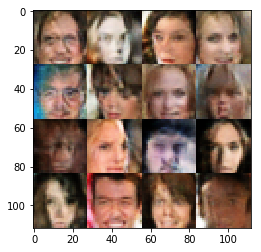

Epoch 5/50... 80.59%... Discriminator Loss: 1.2038... Generator Loss: 0.8003
Epoch 5/50... 81.54%... Discriminator Loss: 1.2426... Generator Loss: 0.6852
Epoch 5/50... 82.49%... Discriminator Loss: 1.0799... Generator Loss: 0.9882
Epoch 5/50... 83.44%... Discriminator Loss: 1.1839... Generator Loss: 0.6844
Epoch 5/50... 84.39%... Discriminator Loss: 0.8538... Generator Loss: 1.2892
Epoch 5/50... 85.34%... Discriminator Loss: 0.9264... Generator Loss: 1.5880
Epoch 5/50... 86.28%... Discriminator Loss: 1.1672... Generator Loss: 0.7654
Epoch 5/50... 87.23%... Discriminator Loss: 1.1091... Generator Loss: 1.0465
Epoch 5/50... 88.18%... Discriminator Loss: 0.8963... Generator Loss: 1.1049
Epoch 5/50... 89.13%... Discriminator Loss: 1.2374... Generator Loss: 0.5098
Epoch 5/50... 90.08%... Discriminator Loss: 0.8683... Generator Loss: 1.1556
Epoch 5/50... 91.02%... Discriminator Loss: 0.8967... Generator Loss: 1.1604
Epoch 5/50... 91.97%... Discriminator Loss: 1.0016... Generator Loss: 0.7636

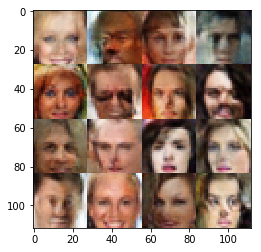

Epoch 6/50... 0.95%... Discriminator Loss: 1.1256... Generator Loss: 0.7934
Epoch 6/50... 1.90%... Discriminator Loss: 1.0568... Generator Loss: 0.9722
Epoch 6/50... 2.84%... Discriminator Loss: 1.0718... Generator Loss: 0.8421
Epoch 6/50... 3.79%... Discriminator Loss: 0.8793... Generator Loss: 1.0013
Epoch 6/50... 4.74%... Discriminator Loss: 1.5682... Generator Loss: 0.5558
Epoch 6/50... 5.69%... Discriminator Loss: 0.7727... Generator Loss: 1.7932
Epoch 6/50... 6.64%... Discriminator Loss: 1.3460... Generator Loss: 0.6498
Epoch 6/50... 7.59%... Discriminator Loss: 1.0265... Generator Loss: 0.9596
Epoch 6/50... 8.53%... Discriminator Loss: 1.2870... Generator Loss: 1.0079
Epoch 6/50... 9.48%... Discriminator Loss: 0.8703... Generator Loss: 0.9092
Epoch 6/50... 10.43%... Discriminator Loss: 1.0265... Generator Loss: 0.8314
Epoch 6/50... 11.38%... Discriminator Loss: 1.1392... Generator Loss: 0.9272
Epoch 6/50... 12.33%... Discriminator Loss: 1.0707... Generator Loss: 0.8437
Epoch 6/5

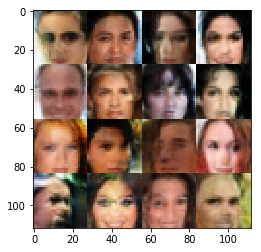

Epoch 6/50... 60.68%... Discriminator Loss: 1.1666... Generator Loss: 0.7525
Epoch 6/50... 61.63%... Discriminator Loss: 0.8195... Generator Loss: 1.1399
Epoch 6/50... 62.58%... Discriminator Loss: 1.2234... Generator Loss: 0.6650
Epoch 6/50... 63.53%... Discriminator Loss: 1.5927... Generator Loss: 0.7378
Epoch 6/50... 64.48%... Discriminator Loss: 1.1002... Generator Loss: 0.8707
Epoch 6/50... 65.42%... Discriminator Loss: 1.0638... Generator Loss: 1.1431
Epoch 6/50... 66.37%... Discriminator Loss: 1.2323... Generator Loss: 0.7006
Epoch 6/50... 67.32%... Discriminator Loss: 0.9643... Generator Loss: 0.9444
Epoch 6/50... 68.27%... Discriminator Loss: 0.8210... Generator Loss: 1.3327
Epoch 6/50... 69.22%... Discriminator Loss: 0.9161... Generator Loss: 0.9965
Epoch 6/50... 70.16%... Discriminator Loss: 0.7857... Generator Loss: 1.7459
Epoch 6/50... 71.11%... Discriminator Loss: 0.9135... Generator Loss: 1.1568
Epoch 6/50... 72.06%... Discriminator Loss: 0.9562... Generator Loss: 0.8817

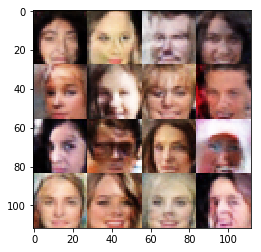

Epoch 6/50... 80.59%... Discriminator Loss: 1.3767... Generator Loss: 1.1654
Epoch 6/50... 81.54%... Discriminator Loss: 0.9087... Generator Loss: 1.1496
Epoch 6/50... 82.49%... Discriminator Loss: 0.8748... Generator Loss: 1.1874
Epoch 6/50... 83.44%... Discriminator Loss: 1.0257... Generator Loss: 0.9176
Epoch 6/50... 84.39%... Discriminator Loss: 1.0015... Generator Loss: 1.0898
Epoch 6/50... 85.34%... Discriminator Loss: 0.8293... Generator Loss: 1.3189
Epoch 6/50... 86.28%... Discriminator Loss: 0.9129... Generator Loss: 1.4003
Epoch 6/50... 87.23%... Discriminator Loss: 1.2122... Generator Loss: 1.1840
Epoch 6/50... 88.18%... Discriminator Loss: 1.1399... Generator Loss: 0.7286
Epoch 6/50... 89.13%... Discriminator Loss: 1.2708... Generator Loss: 0.5508
Epoch 6/50... 90.08%... Discriminator Loss: 0.9083... Generator Loss: 1.1097
Epoch 6/50... 91.02%... Discriminator Loss: 0.8563... Generator Loss: 1.1043
Epoch 6/50... 91.97%... Discriminator Loss: 1.2482... Generator Loss: 0.5259

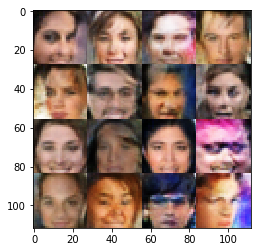

Epoch 7/50... 0.95%... Discriminator Loss: 0.9644... Generator Loss: 1.5876
Epoch 7/50... 1.90%... Discriminator Loss: 0.9638... Generator Loss: 1.4213
Epoch 7/50... 2.84%... Discriminator Loss: 0.9666... Generator Loss: 1.2254
Epoch 7/50... 3.79%... Discriminator Loss: 1.2196... Generator Loss: 0.8609
Epoch 7/50... 4.74%... Discriminator Loss: 1.0099... Generator Loss: 1.0173
Epoch 7/50... 5.69%... Discriminator Loss: 0.9746... Generator Loss: 1.3960
Epoch 7/50... 6.64%... Discriminator Loss: 1.1863... Generator Loss: 0.5651
Epoch 7/50... 7.59%... Discriminator Loss: 0.9486... Generator Loss: 0.9366
Epoch 7/50... 8.53%... Discriminator Loss: 0.9792... Generator Loss: 1.0081
Epoch 7/50... 9.48%... Discriminator Loss: 0.8814... Generator Loss: 1.4993
Epoch 7/50... 10.43%... Discriminator Loss: 1.1275... Generator Loss: 0.6873
Epoch 7/50... 11.38%... Discriminator Loss: 1.0324... Generator Loss: 0.8995
Epoch 7/50... 12.33%... Discriminator Loss: 1.0269... Generator Loss: 0.9979
Epoch 7/5

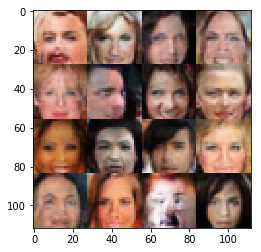

Epoch 7/50... 20.86%... Discriminator Loss: 0.9332... Generator Loss: 1.1438
Epoch 7/50... 21.81%... Discriminator Loss: 0.7291... Generator Loss: 1.3300
Epoch 7/50... 22.76%... Discriminator Loss: 1.0502... Generator Loss: 0.6658
Epoch 7/50... 23.70%... Discriminator Loss: 0.8461... Generator Loss: 0.9844
Epoch 7/50... 24.65%... Discriminator Loss: 1.4028... Generator Loss: 0.5257
Epoch 7/50... 25.60%... Discriminator Loss: 0.8516... Generator Loss: 1.1626
Epoch 7/50... 26.55%... Discriminator Loss: 1.4116... Generator Loss: 0.8036
Epoch 7/50... 27.50%... Discriminator Loss: 1.0507... Generator Loss: 0.8767
Epoch 7/50... 28.45%... Discriminator Loss: 1.1269... Generator Loss: 0.9565
Epoch 7/50... 29.39%... Discriminator Loss: 0.9992... Generator Loss: 1.3722
Epoch 7/50... 30.34%... Discriminator Loss: 1.0185... Generator Loss: 0.8229
Epoch 7/50... 31.29%... Discriminator Loss: 0.8356... Generator Loss: 1.1558
Epoch 7/50... 32.24%... Discriminator Loss: 1.0323... Generator Loss: 1.1864

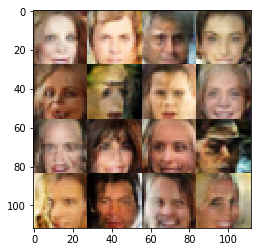

Epoch 7/50... 40.77%... Discriminator Loss: 1.2737... Generator Loss: 2.2600
Epoch 7/50... 41.72%... Discriminator Loss: 1.1116... Generator Loss: 0.7629
Epoch 7/50... 42.67%... Discriminator Loss: 0.9674... Generator Loss: 1.0063
Epoch 7/50... 43.62%... Discriminator Loss: 1.0005... Generator Loss: 0.9136
Epoch 7/50... 44.56%... Discriminator Loss: 0.9373... Generator Loss: 1.1144
Epoch 7/50... 45.51%... Discriminator Loss: 1.1213... Generator Loss: 0.7962
Epoch 7/50... 46.46%... Discriminator Loss: 1.3854... Generator Loss: 0.8530
Epoch 7/50... 47.41%... Discriminator Loss: 1.2922... Generator Loss: 0.5590
Epoch 7/50... 48.36%... Discriminator Loss: 1.2215... Generator Loss: 0.5385
Epoch 7/50... 49.30%... Discriminator Loss: 1.0772... Generator Loss: 0.8037
Epoch 7/50... 50.25%... Discriminator Loss: 1.0499... Generator Loss: 0.8407
Epoch 7/50... 51.20%... Discriminator Loss: 0.3831... Generator Loss: 3.6556
Epoch 7/50... 52.15%... Discriminator Loss: 1.1412... Generator Loss: 0.7057

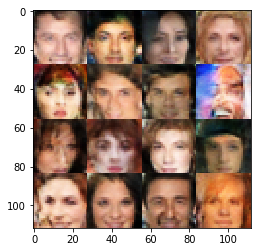

Epoch 7/50... 60.68%... Discriminator Loss: 1.1788... Generator Loss: 0.9350
Epoch 7/50... 61.63%... Discriminator Loss: 1.2316... Generator Loss: 0.5908
Epoch 7/50... 62.58%... Discriminator Loss: 1.1212... Generator Loss: 1.0126
Epoch 7/50... 63.53%... Discriminator Loss: 0.9875... Generator Loss: 1.6291
Epoch 7/50... 64.48%... Discriminator Loss: 1.1737... Generator Loss: 0.7491
Epoch 7/50... 65.42%... Discriminator Loss: 1.1337... Generator Loss: 1.0391
Epoch 7/50... 66.37%... Discriminator Loss: 1.3650... Generator Loss: 0.4405
Epoch 7/50... 67.32%... Discriminator Loss: 0.7641... Generator Loss: 1.0286
Epoch 7/50... 68.27%... Discriminator Loss: 1.0234... Generator Loss: 1.2540


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 50

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.